### Import required packages

In [1]:
import os
import re
import json
import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from factory_func import plot_confusion_matrix
from sklearn.preprocessing import Normalizer
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, f1_score, roc_curve

In [49]:
from keras.layers import Input, Dense, Embedding, Conv1D, Conv2D, Lambda, LSTM, ConvLSTM2D, TimeDistributed, Masking, Bidirectional
from keras.layers import Reshape, Flatten, Dropout, Concatenate, Activation, MaxPooling1D, GlobalAveragePooling1D, MaxPooling2D, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing import sequence
from keras.models import Model, load_model, Sequential
from keras.optimizers import Adam
from keras.utils import to_categorical
import keras.backend as K

In [3]:
import gzip
from gensim.models import Word2Vec

### 1. ETL & Cleansing  
### 2. Rebalancing (Undersampling)  
### 3. Feature Extraction  
### 4. Model Selection & Evaluation  

## Emotion Analysis  
### Accuracy Records  
SVM: 45.5172%  
Dense NN: 45.1724%  
CNN: 47.2414%  
LSTM: tbc  
  
*(there might be a ceiling for how much you can improve the accuracy)*

In [4]:
dev_raw = pd.read_csv(os.path.join(os.getcwd(), 'dev_sent_emo.csv'))
train_raw = pd.read_csv(os.path.join(os.getcwd(), 'train_sent_emo.csv'))
test_raw = pd.read_csv(os.path.join(os.getcwd(), 'test_sent_emo.csv'))

In [5]:
dev_raw.head()

,Sr No.,Utterance,Speaker,Emotion,Sentiment,Dialogue_ID,Utterance_ID,Season,Episode,StartTime,EndTime
0,1,"Oh my God, hes lost it. Hes totally lost it.",Phoebe,sadness,negative,0,0,4,7,"00:20:57,256","00:21:00,049"
1,2,What?,Monica,surprise,negative,0,1,4,7,"00:21:01,927","00:21:03,261"
2,3,"Or! Or, we could go to the bank, close our acc...",Ross,neutral,neutral,1,0,4,4,"00:12:24,660","00:12:30,915"
3,4,Youre a genius!,Chandler,joy,positive,1,1,4,4,"00:12:32,334","00:12:33,960"
4,5,"Aww, man, now we wont be bank buddies!",Joey,sadness,negative,1,2,4,4,"00:12:34,211","00:12:37,505"


In [6]:
dev_raw.Utterance = dev_raw.Utterance.apply(lambda x: re.sub('\\x92', "'", x))
train_raw.Utterance = train_raw.Utterance.apply(lambda x: re.sub('\\x92', "'", x))
test_raw.Utterance = test_raw.Utterance.apply(lambda x: re.sub('\\x92', "'", x))

In [7]:
x_dev = dev_raw.Utterance
y_dev = dev_raw.Emotion
x_train = train_raw.Utterance
y_train = train_raw.Emotion
x_test = test_raw.Utterance
y_test = test_raw.Emotion
z_dev = dev_raw.Sentiment
z_train = train_raw.Sentiment
z_test = test_raw.Sentiment

### Tfidf + SVM

In [8]:
tfidf = TfidfVectorizer(lowercase=True, stop_words='english', ngram_range=(1,3))
tfidf.fit(x_train)
x_dev_tf = tfidf.transform(x_dev)
x_train_tf = tfidf.transform(x_train)
x_test_tf = tfidf.transform(x_test)

In [224]:
# svd = TruncatedSVD(n_components=300)
# x_dev_tr = svd.fit_transform(x_dev_tf)
# x_train_tr = svd.fit_transform(x_train_tf)
# x_test_tr = svd.fit_transform(x_test_tf)

In [225]:
svm = SVC(C=10, kernel='linear', probability=True)
# param_grid = { 
#     'C': [1,10,100], 'kernel': ['linear', 'rbf']
# }
# clf = GridSearchCV(estimator=svm, param_grid=param_grid, cv=5)
# clf.fit(x_train_tr, y_train)

In [226]:
# clf.best_estimator_

**Best model by GridSearchCV**  
SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,  
decision_function_shape='ovr', degree=3, gamma='auto_deprecated',  
kernel='linear', max_iter=-1, probability=True, random_state=None,  
shrinking=True, tol=0.001, verbose=False)

In [227]:
svm.fit(X=x_train_tf, y=y_train)
y_pred_svm = svm.predict(x_test_tf)

In [16]:
f1_score(y_pred=y_pred_svm, y_true=y_test, average="weighted")

0.42923347861223476

In [228]:
svm_accuracy = 100*np.sum(y_pred_svm==y_test)/len(y_pred_svm)
print('Test accuracy: %.4f%%' % svm_accuracy)

Test accuracy: 45.5172%


### Keras TF-IDF tokenizer + Neural nets

Neural network won't accept sentences with different dimension(i.e. number of words) as input. By padding the inputs, we decide the maximum length of words in a sentence, then zero pads the rest, if the input length is shorter than the designated length. In the case where it exceeds the maximum length, then it will also truncate either from the beginning or from the end.  
*Ref_1* https://keras.io/preprocessing/sequence/  
*Ref_2* https://towardsdatascience.com/another-twitter-sentiment-analysis-with-python-part-11-cnn-word2vec-41f5e28eda74

https://medium.com/@sabber/classifying-yelp-review-comments-using-lstm-and-word-embeddings-part-1-eb2275e4066b
#### Dense - Fully Connected Layers

In [8]:
# For emotion analysis
num_classes = 7
# For sentiment analysis
num_polarities = 3

vocabulary_size = 20000
tokenizer = Tokenizer(num_words= vocabulary_size)
tokenizer.fit_on_texts(x_train)
x_train = tokenizer.texts_to_matrix(x_train, mode='tfidf')
x_test = tokenizer.texts_to_matrix(x_test, mode='tfidf')

In [9]:
# Prep target labels for emotion analysis
targets, uniques = pd.factorize(y_train, sort=True)
y_train = to_categorical(targets, num_classes)

label_map = dict(zip(list(uniques), range(num_classes)))
label_map

{'anger': 0,
 'disgust': 1,
 'fear': 2,
 'joy': 3,
 'neutral': 4,
 'sadness': 5,
 'surprise': 6}

In [10]:
# Prep target labels for sentiment analysis
sen_targets, sen_uniques = pd.factorize(z_train, sort=True)
z_train = to_categorical(sen_targets, num_polarities)

sen_label_map = dict(zip(list(sen_uniques), range(num_polarities)))
sen_label_map

{'negative': 0, 'neutral': 1, 'positive': 2}

In [11]:
# tokenizer.fit_on_sequences(x_dev)
# tokenizer.texts_to_sequences(x_dev)
# tokenizer.texts_to_matrix(x_dev, mode='tfidf')
y_train

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [12]:
y_transf = list(map(label_map.get, y_test))
z_transf = list(map(sen_label_map.get, z_test))
y_true = to_categorical(np.array(y_transf), num_classes)
z_true = to_categorical(np.array(z_transf), num_polarities)
y_true

array([[0., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]], dtype=float32)

In [13]:
dense_checkpts = ModelCheckpoint(filepath=os.path.join(os.getcwd() + '/saved_models/text/emotion/dense.weights.best.hdf5'), 
                               verbose=1, save_best_only=True)

In [14]:
num_classes = 7

dense = Sequential()
dense.add(Dense(32, activation='relu', input_dim=20000))
# model.add(Dropout(0.2))
dense.add(Dense(64, activation='relu'))
dense.add(Dense(128, activation='relu'))
dense.add(Dense(num_classes, activation='softmax'))
dense.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
dense.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32)                640032    
_________________________________________________________________
dense_2 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_3 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_4 (Dense)              (None, 7)                 903       
Total params: 651,367
Trainable params: 651,367
Non-trainable params: 0
_________________________________________________________________


Conv1D is generally good for text, whereas Conv2D is good for audio and images where spatial matter

In [15]:
dense.fit(x_train, y_train, validation_split=0.4, epochs=10, callbacks=[dense_checkpts], verbose=1)

Instructions for updating:
Use tf.cast instead.
Train on 5993 samples, validate on 3996 samples
Epoch 1/10
5993/5993 [==============================] - 3s 427us/step - loss: 1.5417 - acc: 0.4757 - val_loss: 1.4436 - val_acc: 0.4880

Epoch 00001: val_loss improved from inf to 1.44364, saving model to /Users/cheuky/Documents/Code_Blue/ml_nanodegree/capstone/saved_models/text/emotion/dense.weights.best.hdf5
Epoch 2/10
5993/5993 [==============================] - 2s 264us/step - loss: 1.1467 - acc: 0.5985 - val_loss: 1.5058 - val_acc: 0.4735

Epoch 00002: val_loss did not improve from 1.44364
Epoch 3/10
5993/5993 [==============================] - 2s 307us/step - loss: 0.7818 - acc: 0.7280 - val_loss: 1.8114 - val_acc: 0.4770

Epoch 00003: val_loss did not improve from 1.44364
Epoch 4/10
5993/5993 [==============================] - 2s 308us/step - loss: 0.5549 - acc: 0.8079 - val_loss: 2.1546 - val_acc: 0.4700

Epoch 00004: val_loss did not improve from 1.44364
Epoch 5/10
5993/5993 [======

In [20]:
# test_data = pad_sequences(tokenizer.texts_to_sequences(x_test), maxlen=50)
y_pred_dense = dense.predict_classes(x_test)

In [21]:
Counter(y_pred_dense)

Counter({4: 1535, 3: 383, 0: 284, 5: 145, 1: 26, 6: 199, 2: 38})

In [42]:
# test_accuracy = 100*np.sum(y_pred_dense==y_true)/len(y_true)
# print('Test accuracy: %.4f%%' % test_accuracy)
dense_accuracy = dense.evaluate(x_test, y_true, batch_size=128)[1] * 100
print('Test accuracy: %.4f%%' % dense_accuracy)

2610/2610 [==============================] - 0s 82us/step
Test accuracy: 45.8621%


In [22]:
uniques

Index(['anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness', 'surprise'], dtype='object')

__About batch_size__  
Advantages of using a batch size < number of all samples:

- It requires less memory. Since you train the network using fewer samples, the overall training procedure requires less memory. That's especially important if you are not able to fit the whole dataset in your machine's memory.

- Typically networks train faster with mini-batches. That's because we update the weights after each propagation. In our example we've propagated 11 batches (10 of them had 100 samples and 1 had 50 samples) and after each of them we've updated our network's parameters. If we used all samples during propagation we would make only 1 update for the network's parameter.

Disadvantages of using a batch size < number of all samples:

- The smaller the batch the less accurate the estimate of the gradient will be.

#### CNN - Convolutional Layers

In [23]:
num_classes = 7
n_length = x_train.shape[0]
n_features = x_train.shape[1]

x_train_reshaped = x_train.reshape(n_length, n_features, 1)
x_test_reshaped = x_test.reshape(x_test.shape[0], n_features, 1)

In [24]:
cnn_checkpts = ModelCheckpoint(filepath=os.path.join(os.getcwd() + '/saved_models/text/emotion/cnn.weights.best.hdf5'), 
                               verbose=1, save_best_only=True)

In [25]:
def build_CNN(num_classes):
    cnn = Sequential()
    cnn.add(Conv1D(filters=16, kernel_size=2, padding='same', activation='relu', input_shape=(n_features, 1)))
    cnn.add(MaxPooling1D(pool_size=2))
    cnn.add(Conv1D(filters=32, kernel_size=2, padding='same', activation='relu'))
    cnn.add(MaxPooling1D(pool_size=2))
    cnn.add(Conv1D(filters=64, kernel_size=2, padding='same', activation='relu'))
    cnn.add(MaxPooling1D(pool_size=2))
    # cnn.add(GlobalAveragePooling1D())
    cnn.add(Flatten())
    cnn.add(Dense(128, activation='relu'))
    cnn.add(Dense(num_classes, activation='softmax'))
    cnn.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])
    print(cnn.summary())
    return cnn

In [26]:
cnn = build_CNN(num_classes)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 20000, 16)         48        
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 10000, 16)         0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 10000, 32)         1056      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 5000, 32)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 5000, 64)          4160      
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 2500, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 160000)            0         
__________

In [27]:
cnn.fit(x_train_reshaped, y_train, validation_split=0.4, epochs=5, callbacks=[cnn_checkpts], verbose=1)

Train on 5993 samples, validate on 3996 samples
Epoch 1/5
5993/5993 [==============================] - 123s 21ms/step - loss: 1.5272 - acc: 0.4744 - val_loss: 1.4688 - val_acc: 0.4767

Epoch 00001: val_loss improved from inf to 1.46878, saving model to /Users/cheuky/Documents/Code_Blue/ml_nanodegree/capstone/saved_models/text/emotion/cnn.weights.best.hdf5
Epoch 2/5
5993/5993 [==============================] - 126s 21ms/step - loss: 1.2066 - acc: 0.5618 - val_loss: 1.5293 - val_acc: 0.4745

Epoch 00002: val_loss did not improve from 1.46878
Epoch 3/5
5993/5993 [==============================] - 130s 22ms/step - loss: 0.8297 - acc: 0.6971 - val_loss: 1.8249 - val_acc: 0.4637

Epoch 00003: val_loss did not improve from 1.46878
Epoch 4/5
5993/5993 [==============================] - 125s 21ms/step - loss: 0.5794 - acc: 0.7868 - val_loss: 2.2210 - val_acc: 0.4660

Epoch 00004: val_loss did not improve from 1.46878
Epoch 5/5
5993/5993 [==============================] - 121s 20ms/step - loss: 

In [28]:
y_pred_cnn = cnn.predict_classes(x_test_reshaped)
# y_pred_cnn = [np.argmax(x) for x in cnn.predict(x_test_reshaped)]
Counter(y_pred_cnn)

Counter({4: 1647, 0: 183, 3: 235, 5: 117, 1: 28, 6: 363, 2: 37})

In [41]:
# cnn_accuracy = 100*np.sum(y_pred_cnn==y_true)/len(y_pred_cnn)
# print('Test accuracy: %.4f%%' % cnn_accuracy)
cnn_accuracy = cnn.evaluate(x_test_reshaped, y_true, batch_size=128)[1] * 100
print('Test accuracy: %.4f%%' % cnn_accuracy)

2610/2610 [==============================] - 12s 5ms/step
Test accuracy: 46.4751%


In [67]:
# cnn_score = cnn.evaluate(x_test_reshaped, y_pred_cnn, verbose=1)
# print("%s: %.2f%%" % (cnn.metrics_names[1], cnn_score[1]*100))

Serialise the model architecture to JSON

In [18]:
with open(os.path.join(os.getcwd(), "saved_models", "text", "emotion", "cnn.model.json", "w") as json_file:
    json_file.write(cnn.to_json())

In [ ]:
# load json and create model
json_file = open('./saved_models/text/emotion/cnn.json', 'r')
loaded_cnn_json = json_file.read()
json_file.close()
loaded_cnn = model_from_json(loaded_cnn_json)
# load weights into new model
loaded_cnn.load_weights("cnn.weights.best.hdf5")
print("Loaded model from disk")

In [8]:
# ENGLISH_STOP_WORDS

### WordEnbedding + LSTM  
- checkpoint: try a pre-trained embedding layer e.g. GloVe Embedding, Word2Vec  
  
Building the embedding from scratch instead of using pre-trained (*this can be a slower approach, but tailors the model to a specific training dataset*)  

Ref_1: https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/

In [20]:
lstm_checkpts = ModelCheckpoint(filepath=os.path.join(os.getcwd() + '/saved_models/text/emotion/lstm.weights.best.hdf5'), 
                               verbose=1, save_best_only=True)

In [69]:
vocabulary_size = 20000
embedding_size=128
lstm_output_size=64  #70
num_classes=7

lstm = Sequential()
lstm.add(Embedding(input_dim=vocabulary_size, output_dim=embedding_size, input_length=20000))
lstm.add(LSTM(units=lstm_output_size, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
lstm.add(Flatten())
lstm.add(Dense(num_classes, activation='sigmoid'))
          
lstm.compile(loss='categorical_crossentropy',
            optimizer='adam',
            metrics=['accuracy'])
lstm.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, 20000, 128)        2560000   
_________________________________________________________________
lstm_13 (LSTM)               (None, 20000, 64)         49408     
_________________________________________________________________
flatten_9 (Flatten)          (None, 1280000)           0         
_________________________________________________________________
dense_8 (Dense)              (None, 7)                 8960007   
Total params: 11,569,415
Trainable params: 11,569,415
Non-trainable params: 0
_________________________________________________________________


In [70]:
lstm.fit(x_train, y_train, validation_split=0.4, epochs=1, callbacks=[lstm_checkpts], verbose=1)

Train on 5993 samples, validate on 3996 samples
Epoch 1/3
5993/5993 [==============================] - 1072s 179ms/step - loss: 1.5608 - acc: 0.4726 - val_loss: 1.5449 - val_acc: 0.4670

Epoch 00001: val_loss improved from inf to 1.54495, saving model to C:\Users\syip\Desktop\DaSci\Nanodegree\ml_nanodegree\capstone/saved_models/lstm.weights.best.hdf5
Epoch 2/3
5993/5993 [==============================] - 1074s 179ms/step - loss: 1.5429 - acc: 0.4746 - val_loss: 1.5357 - val_acc: 0.4670

Epoch 00002: val_loss improved from 1.54495 to 1.53567, saving model to C:\Users\syip\Desktop\DaSci\Nanodegree\ml_nanodegree\capstone/saved_models/lstm.weights.best.hdf5
Epoch 3/3
5993/5993 [==============================] - 1067s 178ms/step - loss: 1.5419 - acc: 0.4746 - val_loss: 1.5396 - val_acc: 0.4670

Epoch 00003: val_loss did not improve from 1.53567


In [72]:
y_pred_lstm = lstm.predict_classes(x_test)
Counter(y_pred_lstm)

Counter({4: 2610})

In [ ]:
lstm_accuracy = 100*np.sum(y_pred_lstm==y_true)/len(y_pred_lstm)
print('Test accuracy: %.4f%%' % lstm_accuracy)

In [37]:
loaded_lstm = load_model('./saved_models/text/emotion/lstm.weights.best.hdf5')

In [38]:
loaded_lstm.predict_classes(x_test[:6])

array([4, 4, 4, 4, 4, 4], dtype=int64)

### WordEmbedding + ConvLSTM

In [66]:
max_features=20000
embedding_size=128
lstm_output_size=32  #70
num_classes=7

conv_lstm = Sequential()
conv_lstm.add(Embedding(input_dim=max_features, output_dim=embedding_size, input_length=20000))
conv_lstm.add(Dropout(0.25))
conv_lstm.add(Conv1D(filters=64,
                 kernel_size=5,
                 padding='valid',
                 activation='relu',
                 strides=1))
conv_lstm.add(MaxPooling1D(pool_size=4))
conv_lstm.add(LSTM(units=lstm_output_size, return_sequences=True))
conv_lstm.add(Flatten())
conv_lstm.add(Dense(num_classes, activation='softmax'))

conv_lstm.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
conv_lstm.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 20000, 128)        2560000   
_________________________________________________________________
dropout_8 (Dropout)          (None, 20000, 128)        0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 19996, 64)         41024     
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 4999, 64)          0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 4999, 32)          12416     
_________________________________________________________________
flatten_6 (Flatten)          (None, 159968)            0         
_________________________________________________________________
dense_7 (Dense)              (None, 7)                 1119783   
Total para

In [ ]:
conv_lstm_checkpts = ModelCheckpoint(filepath=os.path.join(os.getcwd() + '/saved_models/text/emotion/conv_lstm.weights.best.hdf5'), 
                               verbose=1, save_best_only=True)

In [ ]:
conv_lstm.fit(x_train, y_train, validation_split=0.4, callback=[conv_lstm_checkpts], epochs=1, verbose=1)

In [22]:
y_pred_conv_lstm = conv_lstm.predict_classes(x_test)
Counter(y_pred_conv_lstm)

Counter({4: 2610})

In [25]:
conv_lstm_accuracy = 100*np.sum(y_pred_conv_lstm==y_true)/len(y_true)
print('Test accuracy: %.4f%%' % conv_lstm_accuracy)

Test accuracy: 0.0000%


C:\Users\syip\anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  """Entry point for launching an IPython kernel.


### Word2Vec  
Do transfer learning with pre-trained word embedding layers, such as Word2Vec & GloVe

In [ ]:
x_dev_tokens = [sentence.split() for sentence in x_dev]
x_train_tokens = [sentence.split() for sentence in x_train]

model = Word2Vec(
    x_train_tokens,
    size=150,
    window=10,
    min_count=2,
    workers=10)

The first parameter passed to gensim.models.Word2Vec is an iterable of sentences. Sentences themselves are a list of words

In [ ]:
model.train(x_train_tokens, total_examples=len(x_train), epochs=10)

w = ['good']
# w = filter(lambda x: x in model.vocab, x_train.tokens)
model.wv.most_similar(positive=w,
#                       topn=6
                     )

### GloVe

Extract word embeddings from the Glove

In [46]:
embeddings_index = dict()
f = open('../../saved_models/glove.6B.100d.txt', encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

Create a weight matrix

In [47]:
vocabulary_size=20000

embedding_matrix = np.zeros((vocabulary_size, 100))
for word, index in tokenizer.word_index.items():
    if index > vocabulary_size - 1:
        break
    else:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector

Create ConvLSTM model with GloVe

In [54]:
def build_ConvLSTM(num_classes, dense_activation=None, optimizer=None, use_glove=None):
    dense_activation = dense_activation or 'sigmoid'
    optimizer = optimizer or 'adam'
    use_glove = use_glove or True
    max_features=20000
    embedding_size=100
    lstm_output_size=128
    
    model = Sequential()
    if use_glove:
        model.add(Embedding(input_dim=vocabulary_size, output_dim=embedding_size, input_length=20000,
                            weights=[embedding_matrix], trainable=False))
    else:
        model.add(Embedding(input_dim=vocabulary_size, output_dim=embedding_size, input_length=20000))
    model.add(Dropout(0.2))
    model.add(Conv1D(filters=64,
                     kernel_size=5,
                     padding='valid',
                     activation='relu',
                     strides=1))
    model.add(MaxPooling1D(pool_size=4))
    model.add(LSTM(units=lstm_output_size, return_sequences=True))
    model.add(BatchNormalization())
    model.add(TimeDistributed(Dense(32)))
#     model.add(Flatten())
    model.add(GlobalAveragePooling1D())
    model.add(Dense(num_classes, activation=dense_activation))
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    print(model.summary())
    return model

In [17]:
glove_checkpts = ModelCheckpoint(filepath=os.path.join(os.getcwd() + '/saved_models/text/emotion/glove.weights.best.hdf5'), 
                               verbose=1, save_best_only=True)

glove.fit(x_train, y_train, validation_split=0.4, epochs=1, callbacks=[glove_checkpts], verbose=1)

Instructions for updating:
Use tf.cast instead.
Train on 5993 samples, validate on 3996 samples
Epoch 1/1
5993/5993 [==============================] - ETA: 3:19:05 - loss: 1.9459 - acc: 0.18 - ETA: 3:15:05 - loss: 1.9447 - acc: 0.34 - ETA: 3:07:14 - loss: 1.9431 - acc: 0.40 - ETA: 3:03:22 - loss: 1.9421 - acc: 0.41 - ETA: 3:02:30 - loss: 1.9413 - acc: 0.40 - ETA: 3:00:31 - loss: 1.9404 - acc: 0.39 - ETA: 2:58:45 - loss: 1.9382 - acc: 0.40 - ETA: 2:57:20 - loss: 1.9364 - acc: 0.39 - ETA: 2:55:46 - loss: 1.9335 - acc: 0.40 - ETA: 2:54:50 - loss: 1.9295 - acc: 0.40 - ETA: 2:53:49 - loss: 1.9201 - acc: 0.42 - ETA: 2:54:11 - loss: 1.9096 - acc: 0.43 - ETA: 2:53:43 - loss: 1.8961 - acc: 0.43 - ETA: 2:53:01 - loss: 1.8770 - acc: 0.44 - ETA: 2:52:27 - loss: 1.8598 - acc: 0.44 - ETA: 2:52:09 - loss: 1.8400 - acc: 0.45 - ETA: 2:51:38 - loss: 1.8327 - acc: 0.44 - ETA: 2:50:57 - loss: 1.8168 - acc: 0.45 - ETA: 2:48:58 - loss: 1.8044 - acc: 0.45 - ETA: 2:47:00 - loss: 1.7974 - acc: 0.45 - ETA: 2:45

In [18]:
y_pred_glove = glove.predict_classes(x_test)
Counter(y_pred_glove)

Counter({4: 2610})

In [20]:
Counter(targets)

Counter({4: 4710, 6: 1205, 2: 268, 5: 683, 3: 1743, 1: 271, 0: 1109})

## Sentiment Analysis  
__Predicting 3 classes: Positive, Negative & Neutral__  
  
**Models ready at disposal:**  
- svm  
- dense  
- cnn  
- lstm  
- conv_lstm  

**Accuracy records**  
- cnn: 48.5824%  
- lstm with glove: 48.3908%

In [24]:
num_polarities = 3

sen_targets, sen_uniques = pd.factorize(z_train, sort=True)
z_train = to_categorical(sen_targets, num_polarities)

sen_label_map = dict(zip(list(sen_uniques), range(num_polarities)))
sen_label_map

{'negative': 0, 'neutral': 1, 'positive': 2}

In [29]:
Counter(sen_targets)

Counter({1: 4710, 2: 2334, 0: 2945})

### GloVe + LSTM  
Note: To solve the problem of LSTM always predicting the same class even when trained with balanced data, the 'return_sequences' param in the LSTM layer needs to be set to True and add a Flatten layer. In addition, 'return_sequences=True' must be set when stacking LSTM layers so that the second LSTM layer has a three-dimensional sequence inpu

In [55]:
sen_glove = build_ConvLSTM(num_classes=num_polarities, dense_activation='softmax', use_glove=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 20000, 100)        2000000   
_________________________________________________________________
dropout_3 (Dropout)          (None, 20000, 100)        0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 19996, 64)         32064     
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 4999, 64)          0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 4999, 128)         98816     
_________________________________________________________________
batch_normalization_3 (Batch (None, 4999, 128)         512       
_________________________________________________________________
time_distributed_2 (TimeDist (None, 4999, 32)          4128      
__________

Note: to use 'callback', one must provide 'validation_split' or 'validation_data'

In [57]:
glove_checkpts = ModelCheckpoint(filepath=os.path.join(os.getcwd(),'saved_models','text','sentiment','glove.weights.best.hdf5'), 
                               verbose=1, save_best_only=True)

# writing history is for plotting the graph later
glove_history = sen_glove.fit(x_train, z_train, validation_split=0.4, epochs=5, callbacks=[glove_checkpts], verbose=1)

Train on 5993 samples, validate on 3996 samples
Epoch 1/5
5993/5993 [==============================] - 2918s 487ms/step - loss: 1.0511 - acc: 0.4716 - val_loss: 2.3347 - val_acc: 0.2367

Epoch 00001: val_loss improved from inf to 2.33468, saving model to /Users/cheuky/Documents/Code_Blue/ml_nanodegree/capstone/saved_models/text/sentiment/glove.weights.best.hdf5
Epoch 2/5
5993/5993 [==============================] - 1648s 275ms/step - loss: 1.0476 - acc: 0.4759 - val_loss: 1.2299 - val_acc: 0.2370

Epoch 00002: val_loss improved from 2.33468 to 1.22994, saving model to /Users/cheuky/Documents/Code_Blue/ml_nanodegree/capstone/saved_models/text/sentiment/glove.weights.best.hdf5
Epoch 3/5
5993/5993 [==============================] - 1758s 293ms/step - loss: 1.0459 - acc: 0.4746 - val_loss: 1.7933 - val_acc: 0.2963

Epoch 00003: val_loss did not improve from 1.22994
Epoch 4/5
 928/5993 [===>..........................] - ETA: 22:05 - loss: 1.0398 - acc: 0.4849

KeyboardInterrupt: 

In [58]:
z_pred_glove = sen_glove.predict_classes(x_test)
Counter(z_pred_glove)

Counter({1: 2573, 0: 37})

In [61]:
glove_accuracy = 100*np.sum(z_pred_glove==z_transf)/len(z_transf)
print('Test accuracy: %.4f%%' % glove_accuracy)

Test accuracy: 48.3908%


In [58]:
len(z_pred_glove), len(z_true)

(2610, 2610)

In [68]:
# evaluate the model
_, train_acc = sen_glove.evaluate(x_train, z_train, verbose=0)
_, test_acc = sen_glove.evaluate(x_test, z_true, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

Train: 0.495, Test: 0.484


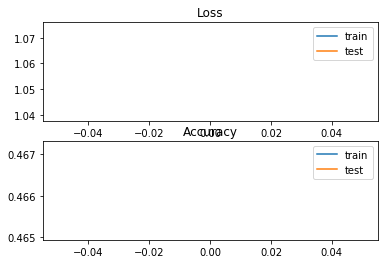

In [73]:
# plot loss during training
plt.subplot(211)
plt.title('Loss')
plt.plot(glove_history.history['loss'], label='train')
plt.plot(glove_history.history['val_loss'], label='test')
plt.legend()
# plot accuracy during training
plt.subplot(212)
plt.title('Accuracy')
plt.plot(glove_history.history['acc'], label='train')
plt.plot(glove_history.history['val_acc'], label='test')
plt.legend()
plt.show()

### CNN

In [25]:
cnn_checkpts = ModelCheckpoint(filepath=os.path.join(os.getcwd() + '/saved_models/text/sentiment/cnn.weights.best.hdf5'), 
                               verbose=1, save_best_only=True)
sen_cnn = build_CNN(num_polarities)
sen_cnn.fit(x_train_reshaped, z_train, validation_split=0.4, epochs=5, callbacks=[cnn_checkpts], verbose=1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_7 (Conv1D)            (None, 20000, 16)         48        
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 10000, 16)         0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 10000, 32)         1056      
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 5000, 32)          0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 5000, 64)          4160      
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 2500, 64)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 160000)            0         
__________

5993/5993 [==============================] - ETA: 2:07 - loss: 0.9519 - acc: 0.468 - ETA: 2:10 - loss: 0.9183 - acc: 0.562 - ETA: 2:11 - loss: 0.8883 - acc: 0.625 - ETA: 2:10 - loss: 0.8919 - acc: 0.617 - ETA: 2:10 - loss: 0.8930 - acc: 0.618 - ETA: 2:11 - loss: 0.8927 - acc: 0.614 - ETA: 2:11 - loss: 0.8899 - acc: 0.620 - ETA: 2:12 - loss: 0.8865 - acc: 0.628 - ETA: 2:11 - loss: 0.8904 - acc: 0.618 - ETA: 2:10 - loss: 0.8894 - acc: 0.615 - ETA: 2:10 - loss: 0.8791 - acc: 0.622 - ETA: 2:08 - loss: 0.8781 - acc: 0.606 - ETA: 2:07 - loss: 0.8722 - acc: 0.605 - ETA: 2:06 - loss: 0.8611 - acc: 0.611 - ETA: 2:05 - loss: 0.8659 - acc: 0.604 - ETA: 2:04 - loss: 0.8626 - acc: 0.601 - ETA: 2:03 - loss: 0.8552 - acc: 0.606 - ETA: 2:03 - loss: 0.8450 - acc: 0.618 - ETA: 2:02 - loss: 0.8456 - acc: 0.616 - ETA: 2:01 - loss: 0.8428 - acc: 0.615 - ETA: 2:00 - loss: 0.8419 - acc: 0.617 - ETA: 2:00 - loss: 0.8465 - acc: 0.613 - ETA: 2:00 - loss: 0.8477 - acc: 0.615 - ETA: 1:59 - loss: 0.8439 - acc: 0.6

5993/5993 [==============================] - ETA: 2:27 - loss: 0.3017 - acc: 0.906 - ETA: 2:21 - loss: 0.3332 - acc: 0.906 - ETA: 2:17 - loss: 0.3287 - acc: 0.916 - ETA: 2:19 - loss: 0.3678 - acc: 0.882 - ETA: 2:25 - loss: 0.3684 - acc: 0.893 - ETA: 2:24 - loss: 0.3992 - acc: 0.864 - ETA: 2:25 - loss: 0.3887 - acc: 0.875 - ETA: 2:23 - loss: 0.3885 - acc: 0.875 - ETA: 2:21 - loss: 0.3889 - acc: 0.871 - ETA: 2:21 - loss: 0.3822 - acc: 0.871 - ETA: 2:19 - loss: 0.3742 - acc: 0.872 - ETA: 2:18 - loss: 0.3694 - acc: 0.880 - ETA: 2:17 - loss: 0.3708 - acc: 0.875 - ETA: 2:16 - loss: 0.3683 - acc: 0.877 - ETA: 2:15 - loss: 0.3736 - acc: 0.877 - ETA: 2:14 - loss: 0.3851 - acc: 0.869 - ETA: 2:13 - loss: 0.3842 - acc: 0.869 - ETA: 2:13 - loss: 0.3846 - acc: 0.868 - ETA: 2:13 - loss: 0.3781 - acc: 0.870 - ETA: 2:14 - loss: 0.3821 - acc: 0.870 - ETA: 2:14 - loss: 0.3895 - acc: 0.866 - ETA: 2:13 - loss: 0.3831 - acc: 0.866 - ETA: 2:14 - loss: 0.3714 - acc: 0.872 - ETA: 2:13 - loss: 0.3789 - acc: 0.8

In [26]:
z_pred_cnn = sen_cnn.predict_classes(x_test_reshaped)
Counter(z_pred_cnn)

Counter({1: 1339, 0: 751, 2: 520})

In [62]:
cnn_accuracy = 100*np.sum(z_pred_cnn==z_transf)/len(z_transf)
print('Test accuracy: %.4f%%' % cnn_accuracy)

Test accuracy: 48.5824%
